# Assignment 6: Urban Street Networks and Interactive Web Maps
**11-20-2022**
## Haobing Liu


* **Part 1: Visualizing crash data in Philadelphia**

In this section, I am going to use `osmnx` to analyze the crash incidence in Center City in Philadelphia. 

* **Part 2: Interactive web maps in Folium**

In this section, I will visualize a geospatial data set, queried using an API, using Folium in Python.

## Part 1: Visualizing crash data in Philadelphia

### 1.1 Load the geometry for the region being analyzed

1. In this step, I'm gonna analyze crashes in the "Central" planning district in Philadelphia, a rough approximation for Center City. [Planning districts](https://www.opendataphilly.org/dataset/planning-districts) can be loaded from Open Data Philly. Read the data into a GeoDataFrame using the following link:
http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson



In [1]:
import json
import folium
import requests
import carto2gpd
import matplotlib
import osmnx as ox
import numpy as np
import pandas as pd
import altair as alt
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import IFrame
from folium.plugins import HeatMap
import matplotlib.colors as mcolors

In [2]:
# get districts data
districts = gpd.read_file('http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson')
districts.head()

OBJECTID_1  OBJECTID             DIST_NAME ABBREV   Shape__Area  \
0           1        14           River Wards     RW  2.107270e+08   
1           2         3        North Delaware   NDEL  2.700915e+08   
2           3         0   Lower Far Northeast   LFNE  3.068529e+08   
3           4         9               Central    CTR  1.782880e+08   
4           5        10  University Southwest    USW  1.296468e+08   

   Shape__Length PlanningDist DaytimePop  \
0   66931.595020         None       None   
1   89213.074378         None       None   
2   92703.285159         None       None   
3   71405.143450         None       None   
4   65267.676141         None       None   

                                            geometry  
0  POLYGON ((-75.09798 40.00496, -75.09687 40.005...  
1  POLYGON ((-74.98159 40.05363, -74.98139 40.053...  
2  POLYGON ((-74.96443 40.11728, -74.96434 40.117...  
3  POLYGON ((-75.14791 39.96733, -75.14715 39.967...  
4  POLYGON ((-75.18742 39.96338, -75.18644 39.963...

2. Select the "Central" district and extract the geometry polygon for only this district. 

In [3]:
select = districts['DIST_NAME'].isin(['Central'])
central = districts.loc[select]
central.head()

OBJECTID_1  OBJECTID DIST_NAME ABBREV   Shape__Area  Shape__Length  \
3           4         9   Central    CTR  1.782880e+08    71405.14345   

  PlanningDist DaytimePop                                           geometry  
3         None       None  POLYGON ((-75.14791 39.96733, -75.14715 39.967...

In [4]:
type(central)

geopandas.geodataframe.GeoDataFrame

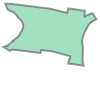

In [5]:
central_outline = central.geometry.unary_union
central_outline

In [6]:
type(central_outline)

shapely.geometry.polygon.Polygon

Now I have a polygon variable `central_outline` of type `shapely.geometry.polygon.Polygon`.

### 1.2 Get the street network graph

Use `OSMnx` to create a network graph (of type 'drive') from polygon boundary in 1.1.

In [7]:
# get the graph
G = ox.graph_from_polygon(central_outline, network_type='drive')

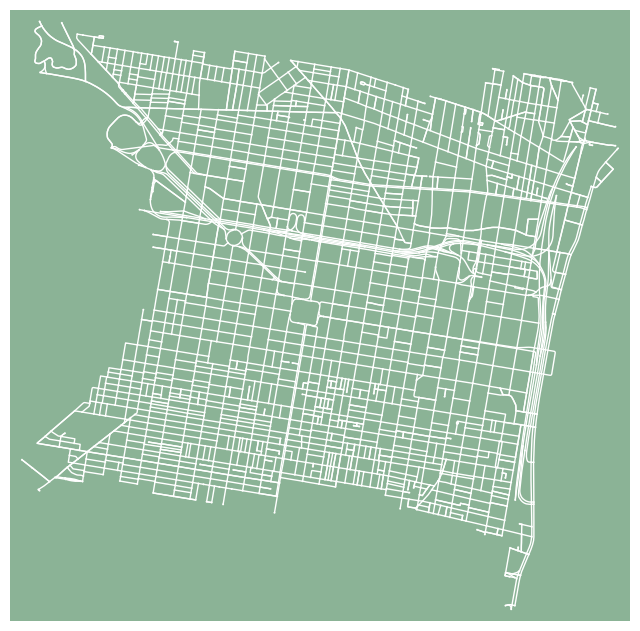

In [8]:
ox.plot_graph(ox.project_graph(G), 
              node_size=2,
              bgcolor="#8bb396",
              edge_color='white'
             );

### 1.3 Convert your network graph edges to a GeoDataFrame

Use `OSMnx` to create a GeoDataFrame of the network edges in the graph object from part 1.2. 

The GeoDataFrame should contain the edges but not the nodes from the network.

In [9]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [10]:
# only get the edges
central_edges = ox.graph_to_gdfs(G, 
                                edges=True, 
                                nodes=False)

# we have lots of data associated with each edge!
central_edges.head()

osmid  oneway                   name  \
u         v         key                                             
109727439 109911666 0    132508434    True      Bainbridge Street   
109727448 109727439 0     12109011    True  South Colorado Street   
          110034229 0     12159387    True       Fitzwater Street   
109727507 110024052 0    193364514    True       Carpenter Street   
109728761 110274344 0    672312336    True           Brown Street   

                             highway reversed   length  \
u         v         key                                  
109727439 109911666 0    residential    False   44.137   
109727448 109727439 0    residential    False  109.484   
          110034229 0    residential    False   91.353   
109727507 110024052 0    residential    False   53.208   
109728761 110274344 0    residential    False   58.270   

                                                                  geometry  \
u         v         key                                                      
109727439 109911666 0    LINESTRING (-75.17104 39.94345, -75.17053 39.9...   
109727448 109727439 0    LINESTRING (-75.17125 39.94248, -75.17120 39.9...   
          110034229 0    LINESTRING (-75.17125 39.94248, -75.17137 39.9...   
109727507 110024052 0    LINESTRING (-75.17196 39.93973, -75.17134 39.9...   
109728761 110274344 0    LINESTRING (-75.17317 39.96951, -75.17250 39.9...   

                        lanes maxspeed tunnel bridge  ref width service  \
u         v         key                                                   
109727439 109911666 0     NaN      NaN    NaN    NaN  NaN   NaN     NaN   
109727448 109727439 0     NaN      NaN    NaN    NaN  NaN   NaN     NaN   
          110034229 0     NaN      NaN    NaN    NaN  NaN   NaN     NaN   
109727507 110024052 0     NaN      NaN    NaN    NaN  NaN   NaN     NaN   
109728761 110274344 0     NaN      NaN    NaN    NaN  NaN   NaN     NaN   

                        access junction  
u         v         key                  
109727439 109911666 0      NaN      NaN  
109727448 109727439 0      NaN      NaN  
          110034229 0      NaN      NaN  
109727507 110024052 0      NaN      NaN  
109728761 110274344 0      NaN      NaN

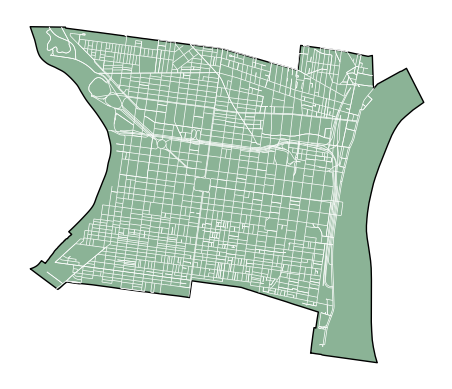

In [11]:
# plot it like any old GeoDataFrame
ax3 = central_edges.to_crs(epsg=2272).plot(color='white', linewidth=0.5)

# add the central area boundary
boundary = gpd.GeoSeries([central_outline], crs='EPSG:4326')
boundary.to_crs(epsg=2272).plot(ax=ax3, facecolor='#8bb396', edgecolor='black', linewidth=1, zorder=1)

ax3.set_axis_off()

In [12]:
type(boundary)

geopandas.geoseries.GeoSeries

### 1.4 Load PennDOT crash data

Data for 2021 crashes (of all types) is available at the following path: `./data/CRASH_PHILADELPHIA_2021.csv`

The data was downloaded for Philadelphia County [from here](https://crashinfo.penndot.gov/PCIT/welcome.html).

In [13]:
crash = pd.read_csv('data/CRASH_PHILADELPHIA_2021.csv') 
type(crash) 

pandas.core.frame.DataFrame

### 1.5 Convert the crash data to a GeoDataFrame

In this step, I'm gonna convert `crash` to `crash_geo` with geometry. The columns I need to use are `DEC_LAT` and `DEC_LONG` for latitude and longitude. The full data dictionary for the data is [available here](http://pennshare.maps.arcgis.com/sharing/rest/content/items/ffe20c6c3c594389b275c6772a281bcd/data)

In [14]:
crash_geo = gpd.GeoDataFrame(crash, geometry=gpd.points_from_xy(crash.DEC_LONG, crash.DEC_LAT))
type(crash_geo)

geopandas.geodataframe.GeoDataFrame

### 1.6 Trim the crash data to Center City

In this step, I need to create a new central area geodataframe:


1. Get the boundary of the edges data frame (from part 1.3). Accessing the `.geometry.unary_union.convex_hull` property will get a nice outer boundary region.

In [15]:
center_area = boundary.geometry.unary_union.convex_hull
type(center_area)

shapely.geometry.polygon.Polygon

2. Trim the crashes using the `within()` function of the crash GeoDataFrame to find which crashes are within the boundary.

In [16]:
points = crash_geo.within(center_area) 

In [17]:
points

0        False
1        False
2         True
3        False
4        False
         ...  
10458    False
10459    False
10460    False
10461     True
10462    False
Length: 10463, dtype: bool

In [18]:
crash_central = crash_geo.loc[points].copy()

In [19]:
crash_central.reset_index(inplace=True, drop=True)

3. Now I get the 1411 crashes within the Central district.

In [20]:
len(crash_central)

1411

### 1.7 Re-project our data into an approriate CRS

In this step, I need to find the nearest edge (street) in the graph for each crash. To do this, `osmnx` will calculate the distance from each crash to the graph edges. For this calculation to be accurate, I need to convert from latitude/longitude. **I will convert the local state plane CRS for Philadelphia, EPSG=2272**

1. Project the graph object (`G`) using the `ox.project_graph`. 

In [21]:
G_2272 = ox.project_graph(G, to_crs='epsg:2272')
G_2272.graph['crs']

<Derived Projected CRS: EPSG:2272>
Name: NAD83 / Pennsylvania South (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Pennsylvania - counties of Adams; Allegheny; Armstrong; Beaver; Bedford; Berks; Blair; Bucks; Butler; Cambria; Chester; Cumberland; Dauphin; Delaware; Fayette; Franklin; Fulton; Greene; Huntingdon; Indiana; Juniata; Lancaster; Lawrence; Lebanon; Lehigh; Mifflin; Montgomery; Northampton; Perry; Philadelphia; Schuylkill; Snyder; Somerset; Washington; Westmoreland; York.
- bounds: (-80.53, 39.71, -74.72, 41.18)
Coordinate Operation:
- name: SPCS83 Pennsylvania South zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

2. Project the crash data using the `.to_crs()` function.

In [22]:
# the reason I set 4326 crs first is that the dataframe needs to get a projection to avoild value error.
# or else I was told that it *cannot transform naive geometries*
crash_central.crs = 'epsg:4326'

#then I set the proper crs for dataframe
crash_central.to_crs(epsg=2272)
crash_central2272 = crash_central.to_crs(epsg=2272)
crash_central2272.crs

<Derived Projected CRS: EPSG:2272>
Name: NAD83 / Pennsylvania South (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Pennsylvania - counties of Adams; Allegheny; Armstrong; Beaver; Bedford; Berks; Blair; Bucks; Butler; Cambria; Chester; Cumberland; Dauphin; Delaware; Fayette; Franklin; Fulton; Greene; Huntingdon; Indiana; Juniata; Lancaster; Lawrence; Lebanon; Lehigh; Mifflin; Montgomery; Northampton; Perry; Philadelphia; Schuylkill; Snyder; Somerset; Washington; Westmoreland; York.
- bounds: (-80.53, 39.71, -74.72, 41.18)
Coordinate Operation:
- name: SPCS83 Pennsylvania South zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 1.8 Find the nearest edge for each crash

1. I will use `ox.distance.nearest_edges()`in this step, which takes three arguments:

- the network graph
- the longitude of your crash data (the `x` attribute of the `geometry` column)
- the latitude of your crash data (the `y` attribute of the `geometry` column)


In [23]:
nearest = ox.distance.nearest_edges(G_2272, X=crash_central2272['geometry'].x, Y=crash_central2272['geometry'].y)

2. Then I get a dataframe with 3 columns that represent `(u, v, key)` where each `u` and `v` are the node IDs that the edge links together. And also I will ignore the `key` value in the next analysis.

In [24]:
nearest_array = np.array(nearest)
nearest_df = pd.DataFrame(nearest_array, columns = ['u','v','key'])
nearest_df

u           v  key
0     1903608761   109775193    0
1     8482829382  7065714513    0
2     7384791791   775424603    0
3     2043885897  5879856051    0
4      109739559   110225812    0
...          ...         ...  ...
1406  5562239293  1888418037    0
1407   109799565   109799300    0
1408   109784213   109789845    0
1409  7738709997  1479201367    0
1410   109770355   109770169    0

[1411 rows x 3 columns]

### 1.9 Calculate the total number of crashes per street

Here are the changes in this section:
* Make a DataFrame from your data from part 1.7 with three columns, `u`, `v`, and `key` (we will only use the `u` and `v` columns). 
* Then group by `u` and `v` and calculate the size
* Reset the index and name your `size()` column as `crash_count`

In [25]:
nearest_count = nearest_df.groupby(['u','v']).count().reset_index().rename(columns={'key':'crash_count'})
nearest_count

u           v  crash_count
0     109729474  3425014859            2
1     109729486   109729699            1
2     109729486   110342146            2
3     109729699   109811674            2
4     109729709   109729731            3
..          ...         ...          ...
496  7738710013   110207010            3
497  8482829382  7065714513           71
498  8553549495   109811783            1
499  9244049904   634779465            2
500  9518379104   110318202           25

[501 rows x 3 columns]

Then I get a DataFrame with three columns: `u`, `v`, and `crash_count`.

### 1.10 Merge  edges GeoDataFrame and crash count DataFrame

I use pandas to merge them on the `u` and `v` columns. This will associate the total crash count with each edge in the street network. 

**Tips:** 
   - Use a `left` merge where the first argument of the merge is the edges GeoDataFrame. This ensures no edges are removed during the merge.
   - Use the `fillna(0)` function to fill in missing crash count values with zero.

In [26]:
central_crash_count = pd.merge(central_edges, nearest_count, how='left', on=['u','v'])
central_crash_count.head()

u          v      osmid  oneway                   name  \
0  109727439  109911666  132508434    True      Bainbridge Street   
1  109727448  109727439   12109011    True  South Colorado Street   
2  109727448  110034229   12159387    True       Fitzwater Street   
3  109727507  110024052  193364514    True       Carpenter Street   
4  109728761  110274344  672312336    True           Brown Street   

       highway reversed   length  \
0  residential    False   44.137   
1  residential    False  109.484   
2  residential    False   91.353   
3  residential    False   53.208   
4  residential    False   58.270   

                                            geometry lanes maxspeed tunnel  \
0  LINESTRING (-75.17104 39.94345, -75.17053 39.9...   NaN      NaN    NaN   
1  LINESTRING (-75.17125 39.94248, -75.17120 39.9...   NaN      NaN    NaN   
2  LINESTRING (-75.17125 39.94248, -75.17137 39.9...   NaN      NaN    NaN   
3  LINESTRING (-75.17196 39.93973, -75.17134 39.9...   NaN      NaN    NaN   
4  LINESTRING (-75.17317 39.96951, -75.17250 39.9...   NaN      NaN    NaN   

  bridge  ref width service access junction  crash_count  
0    NaN  NaN   NaN     NaN    NaN      NaN          NaN  
1    NaN  NaN   NaN     NaN    NaN      NaN          NaN  
2    NaN  NaN   NaN     NaN    NaN      NaN          NaN  
3    NaN  NaN   NaN     NaN    NaN      NaN          NaN  
4    NaN  NaN   NaN     NaN    NaN      NaN          NaN

### 1.11 Calculate a "Crash Index"

Let's calculate a "crash index" that provides a normalized measure of the crash frequency per street.

1. Calculate the total crash count divided by the street length, using the `length` column

In [27]:
central_crash_count['divide_index'] = central_crash_count['crash_count']/central_crash_count['length']

2. Perform a log transformation of the crash/length variable — use numpy's `log10()` function

In [28]:
central_crash_count['log10_index'] = central_crash_count['divide_index'].apply(np.log10)

3. Normalize the index from 0 to 1 (see the lecture notes for an example of this transformation)
**Note: since the crash index involves a log transformation, you should only calculate the index for streets where the crash count is greater than zero**.

In [29]:
# Minimum
min_val = central_crash_count['log10_index'].min()

# Maximum
max_val = central_crash_count['log10_index'].max()

# Calculate a normalized column
normalized = (central_crash_count['log10_index'] - min_val) / (max_val - min_val)

# Add to the dataframe
central_crash_count['index_normalized'] = normalized

Now I have a new column in the data frame from 1.9 that includes a column called part 1.9.

In [30]:
central_crash_count.head()

u          v      osmid  oneway                   name  \
0  109727439  109911666  132508434    True      Bainbridge Street   
1  109727448  109727439   12109011    True  South Colorado Street   
2  109727448  110034229   12159387    True       Fitzwater Street   
3  109727507  110024052  193364514    True       Carpenter Street   
4  109728761  110274344  672312336    True           Brown Street   

       highway reversed   length  \
0  residential    False   44.137   
1  residential    False  109.484   
2  residential    False   91.353   
3  residential    False   53.208   
4  residential    False   58.270   

                                            geometry lanes  ... bridge  ref  \
0  LINESTRING (-75.17104 39.94345, -75.17053 39.9...   NaN  ...    NaN  NaN   
1  LINESTRING (-75.17125 39.94248, -75.17120 39.9...   NaN  ...    NaN  NaN   
2  LINESTRING (-75.17125 39.94248, -75.17137 39.9...   NaN  ...    NaN  NaN   
3  LINESTRING (-75.17196 39.93973, -75.17134 39.9...   NaN  ...    NaN  NaN   
4  LINESTRING (-75.17317 39.96951, -75.17250 39.9...   NaN  ...    NaN  NaN   

  width service access junction crash_count divide_index  log10_index  \
0   NaN     NaN    NaN      NaN         NaN          NaN          NaN   
1   NaN     NaN    NaN      NaN         NaN          NaN          NaN   
2   NaN     NaN    NaN      NaN         NaN          NaN          NaN   
3   NaN     NaN    NaN      NaN         NaN          NaN          NaN   
4   NaN     NaN    NaN      NaN         NaN          NaN          NaN   

   index_normalized  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 22 columns]

### 1.12 Plot a histogram of the crash index values

Use matplotlib's `hist()` function to plot the crash index values from the previous step. As we can see in the histogram, the index values are Gaussian-distributed, providing justification for why I log-transformed! A matplotlib color map in the next step requires data to be between 0 and 1 thus I need to normalize `index_normalized` column to be between 0 and 1.

Text(0.5, 1.0, 'Histogram of the crash index of Central District\nin Philadelphia, 2021')

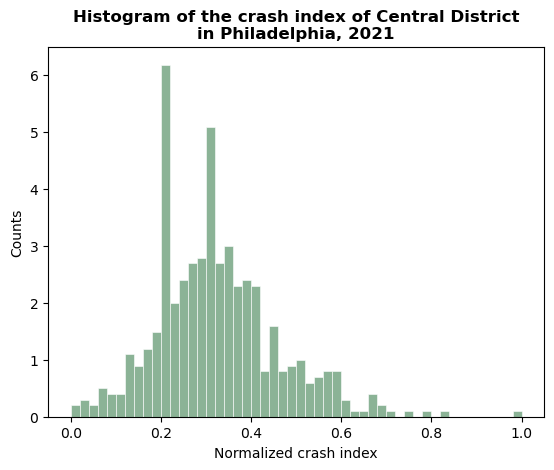

In [31]:
plt.hist(central_crash_count['index_normalized'], 50, density = True, 
         histtype ='bar',
         color = '#8bb396',
         ec = "white",
         lw = 0.4)
plt.xlabel('Normalized crash index')
plt.ylabel('Counts')
  
plt.title('Histogram of the crash index of Central District\nin Philadelphia, 2021',
          fontweight ="bold")

### 1.13 Plot the street networks, colored by the crash index

You can use GeoPandas to make the plot, coloring the streets by the crash index column.

**Tip:** if you use the viridis color map, try setting the facecolor of the axes as black for better constrast of the colors.

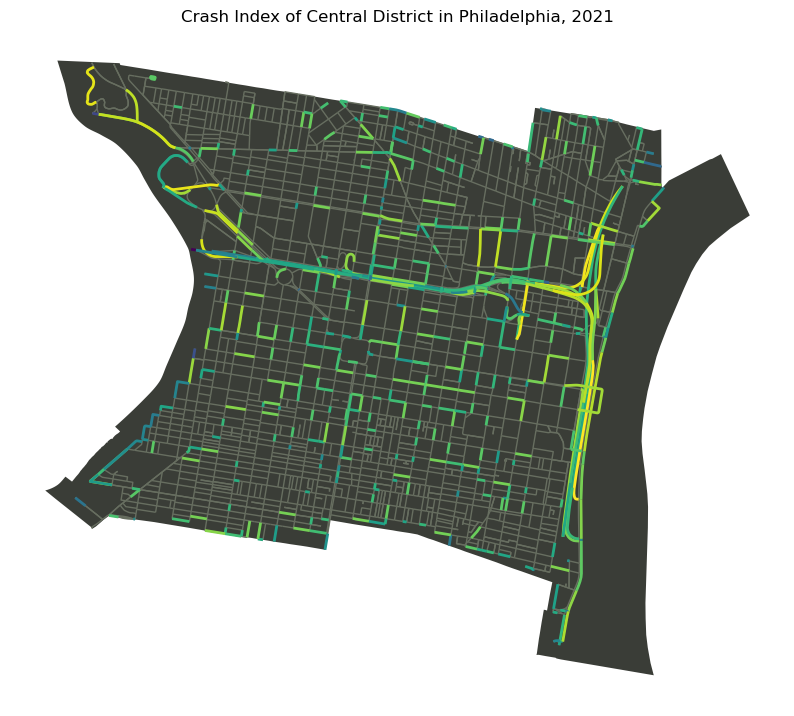

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

central.plot(ax = ax, color = '#3a3d37')
central_edges.plot(ax = ax, color = '#676e60', linewidth=1)
central_crash_count.plot(column ='index_normalized', 
                         ax = ax, 
                         cmap = 'viridis_r',
                         linewidth=2
                        )

ax.set_title('Crash Index of Central District in Philadelphia, 2021')
ax.set_axis_off()

### 1.14 An interactive map of the crash index

In this part, I will use `Folium` to make an interactive version of the map from the previous section. 

1. Remove some unused columns, in this step I only need the "geometry", "crash_index", and "name" columns.

In [33]:
#select the columns I need to plot
cols = ['name', 'index_normalized', 'crash_count', 'geometry']
need_data = central_crash_count[cols]

#drop NA
#if I don't drop the NA, it will return me a error because the ufunc 'isnan' not supported for the input types
need_data = need_data.dropna() 
need_data

name  index_normalized  crash_count  \
14                   Arch Street          0.321899          2.0   
15    North Independence Ml East          0.325336          2.0   
16              North 5th Street          0.021394          1.0   
26             Callowhill Street          0.311233          2.0   
27                 Willow Street          0.311317          2.0   
...                          ...               ...          ...   
3880          North Front Street          0.332399          3.0   
3892      Vine Street Expressway          1.000000         71.0   
3894            North 6th Street          0.306967          1.0   
3913        Spring Garden Street          0.587106          2.0   
3917           South 24th Street          0.750191         25.0   

                                               geometry  
14    LINESTRING (-75.14847 39.95259, -75.14859 39.9...  
15    LINESTRING (-75.14832 39.95333, -75.14813 39.9...  
16    LINESTRING (-75.14832 39.95333, -75.14822 39.9...  
26    LINESTRING (-75.14724 39.95779, -75.14739 39.9...  
27    LINESTRING (-75.14714 39.95860, -75.14788 39.9...  
...                                                 ...  
3880  LINESTRING (-75.13626 39.96884, -75.13627 39.9...  
3892  LINESTRING (-75.17958 39.95998, -75.17911 39.9...  
3894  LINESTRING (-75.14718 39.96702, -75.14729 39.9...  
3913  LINESTRING (-75.13708 39.96018, -75.13730 39.9...  
3917  LINESTRING (-75.17920 39.95268, -75.17922 39.9...  

[473 rows x 4 columns]

2. Pass in GeoJSON data

In [34]:
# Pass in GeoJSON data for central crash data
crash_json = need_data.to_json()

# Pass in GeoJSON data for central street networks
central_json = central_edges.to_json()

In [35]:
cmap = plt.get_cmap('viridis_r')

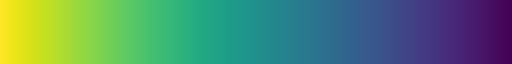

In [36]:
cmap




3. Use a style function that applies a color to the edge geometries based on the value of the "crash index" column. 

-  See the crash index is defined from 0 to 1
-  convert the RGB color returned by the color map to a hex string
-  set the "weight" attribute to change the width of the streets

In [37]:
#define 
def get_neighborhood_style(feature):
    """Return a style dict."""
    return {"color": "#556158",
            "weight": 1.2,
           "fillOpacity": 0.2}


def get_highlighted_style(feature):
    """Return a style dict when highlighting a feature."""
    return {"weight": 3, "color": "orange"}

In [38]:
def get_style(feature):
    """
    Given an input GeoJSON feature, return a style dict.
    
    Notes
    -----
    The color in the style dict is determined by the 
    "index_normalized" column in the input "feature".
    """
    # Get the data value from the feature
    value = feature['properties']['index_normalized']
    
    # Evaluate the color map
    # NOTE: value must between 0 and 1
    rgb_color = cmap(value) # this is an RGB tuple
    
    # Convert to hex string
    color = mcolors.rgb2hex(rgb_color)
    
    # Return the style dictionary
    return {'weight': 3, 
            'color': color, 
            'fillColor': color, 
            "fillOpacity": 1}

4. Add the street edges polygons to the map using the `Folium.GeoJson()` function.  Then Initialize a Folium map centered on Philadelphia. I choose  `Cartodb dark_matter` to use the viridis color map. At the same time,  I will add a GeoJsonTooltip object that includes the street name and crash index value so you can quickly identify which streets have the highest index values.

In [39]:
# STEP 1: Initialize the map
m = folium.Map(
    location=[39.955, -75.16],
    tiles='Cartodb dark_matter',
    zoom_start=13.5
)

# STEP 2: Add the street network GeoJson to the map
folium.GeoJson(
    central_json,
    style_function=get_neighborhood_style, 
    tooltip=folium.GeoJsonTooltip(['name'])
).add_to(m)

# STEP 3: Add the crash street GeoJson to the map
folium.GeoJson(
    crash_json, 
    style_function=get_style, # The style function to color counties differently
    highlight_function=get_highlighted_style, 
    tooltip=folium.GeoJsonTooltip(['name','crash_count'])
).add_to(m)

m

## Part 2: Interactive web maps with Folium

In this part, you'll visualize a geospatial data set, queried using an API, using Folium in Python. The choice of data set is up to you, but must satisfy a few requirements:

- The data must be pulled using an API
- The data should be in GeoJSON format and be Point features (latitude, longitude)
- Use Folium to create a map showing a heat map of the data, using the Leaflet.heat plugin

#### Notes

- See [lecture 10A](https://github.com/MUSA-550-Fall-2022/week-10/blob/main/lecture-10A.ipynb) for example maps using the data set of Philadelphia building permits. **Note: you must choose a data set other than the building permits data set that we used in class**.
- There are several options for data on OpenDataPhilly — any data set hosted on the CARTO SQL database with associated API documentation will work, similar to the shootings data set (you can use the `carto2gpd` library to do the querying).
- You can also choose a different API to use, as long as it satisfies the above requirements. To query the API, you can either use the `requests` module in Python or use `geopandas` directly to read the geojson returned by the API. For example:
  - the [Philadelphia bike share Indego](https://www.rideindego.com/about/data/) has an API of live station data in GeoJSON format: https://www.rideindego.com/stations/json/
  - Data.gov maintains a list of APIs in GeoJSON format: https://catalog.data.gov/dataset?res_format=GeoJSON. Note that not all of these are Point features


### Step 1: Download the data from CARTO

1. This dataset is published to carto, which allows us to query the data using SQL. 

In [40]:
# API URL
url = "https://phl.carto.com/api/v2/sql"

# Table name on CARTO
table_name = "shootings"

### Step 2: Remove missing geometries

2. Query the database API directly to get the GeoJSON, then I use the `carto2gpd` package to get the data.


In [41]:
shootings = carto2gpd.get(url, table_name)

3. Some permits don't have locations — use the `.geometry.notnull()` function to trim the data frame to those incidents with valid geometries.

In [42]:
shootings = shootings.loc[shootings.geometry.notnull()]

In [43]:
len(shootings)

13080

4. Extract out the lat/lng coordinates, then get an array of (latitude, longitude) data. The dataframe has columns forthe latitude(`point_y`)and longitude(`point_x`), so I don't need to extract them from the geometery.

In [44]:
shootings.head()

geometry  cartodb_id  objectid  year          dc_key  \
0  POINT (-75.14207 40.02063)           1   6156898  2022  202235049652.0   
1  POINT (-75.15020 40.04224)           2   6156899  2022  202235063700.0   
3  POINT (-75.14464 40.03694)           4   6156901  2022  202235067083.0   
4  POINT (-75.14608 40.05740)           5   6156902  2022  202235067614.0   
5  POINT (-75.13117 40.03380)           6   6156903  2022  202235067698.0   

  code                 date_      time race sex  ... offender_injured  \
0  111  2022-08-21T00:00:00Z  15:37:00    B   F  ...                N   
1  411  2022-10-23T00:00:00Z  05:45:00    B   M  ...                N   
3  411  2022-11-07T00:00:00Z  12:18:00    B   M  ...                N   
4  411  2022-11-09T00:00:00Z  18:59:00    B   M  ...                N   
5  411  2022-11-10T00:00:00Z  04:43:00    B   M  ...                N   

  offender_deceased                     location latino    point_x    point_y  \
0                 N  1000 BLOCK W WINGOHOCKEN ST    0.0 -75.142068  40.020635   
1                 N        5800 BLOCK OGONTZ AVE    0.0 -75.150202  40.042240   
3                 N     5500 BLOCK OLD YORK ROAD    0.0 -75.144636  40.036944   
4                 N           1700 BLOCK 68TH AV    0.0 -75.146080  40.057398   
5                 N          5400 BLOCK N 5TH ST    0.0 -75.131175  40.033804   

   dist  inside  outside fatal  
0    35     0.0      1.0   1.0  
1    35     0.0      1.0   0.0  
3    35     0.0      1.0   0.0  
4    35     0.0      1.0   0.0  
5    35     1.0      0.0   0.0  

[5 rows x 23 columns]

In [45]:
# Split out the data
fatal = shootings.query("fatal == 1.0")
nonfatal = shootings.query("fatal == 0.0")

In [46]:
len(fatal)

2662

In [47]:
len(nonfatal)

10310

In [48]:
# Split out the gender
fatal_female = fatal.query("sex == 'F'")
fatal_male = fatal.query("sex == 'M'")

In [49]:
len(fatal_female)

217

In [50]:
len(fatal_male)

2445

5. Make a NumPy array (use the `values` attribute)

In [51]:
fatal_coords = fatal[['point_y', 'point_x']].values
nonfatal_coords = nonfatal[['point_y', 'point_x']].values
fatal_female_coords = fatal_female[['point_y', 'point_x']].values
fatal_male_coords = fatal_male[['point_y', 'point_x']].values

### Step 4: Make a Folium map and add a HeatMap

The HeatMap takes the list of coordinates: **the first column is latitude and the second column longitude**

####  2022 Fatal shootings

In [52]:
# Initialize map
m = folium.Map(
    location=[39.99, -75.13],
    tiles='Cartodb Positron',
    zoom_start=12
)


# Add heat map coordinates
HeatMap(fatal_coords,
        gradient={0.1: 'lime', 0.3: '#c2e32d', 0.5: 'yellow', 0.7: 'orange', 1: '#a82413'},
        min_opacity=0.5,
        blur=35).add_to(m)

m

#### Fatal shootings - female

In [53]:
# Initialize map
m = folium.Map(
    location=[39.99, -75.13],
    tiles='Cartodb Positron',
    zoom_start=14
)


HeatMap(fatal_female_coords,
        gradient={0.1: 'lime', 0.3: '#c2e32d', 0.5: 'yellow', 0.7: 'orange', 1: '#a82413'},
        min_opacity=0.5,
        blur=30).add_to(m)

m